In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
dl=.005
lam = np.hstack([np.arange(-50,-1+dl/2,dl),np.arange(1,500+dl/2,dl)])

A,C = (0,1)
a,c = (1,.05)
A_mat = lam

n = len(A_mat)
b_vec = np.ones(n,dtype=np.double)
b_vec /= np.linalg.norm(b_vec)

M = lambda x: (A*x**2+C)
N = lambda x: (a*x**2+c)
f = lambda x: M(x)/N(x)

fAb = f(A_mat)*b_vec

K = 500
Q,(a_,b_) = exact_lanczos(A_mat,b_vec,K,reorth=False)

In [4]:
error_opt = np.full(K,np.nan)

for i in range(1,K):

    # optimal approx
    opt = Q[:,:i]@(Q[:,:i].T@fAb)
    error_opt[i] = np.linalg.norm(fAb - opt)

In [5]:
error_FA = np.full(K,np.nan)

for i in range(1,K):

    # Lanczos-FA
    # solve via eigenvalue because breakdown in factorization
    T = np.diag(a_[:i]) + np.diag(b_[:i-1],1) + np.diag(b_[:i-1],-1)
    lank_FA = Q[:,:i]@np.linalg.solve(a*T@T+c*np.eye(i),(A*T@T+C*np.eye(i))[:,0])
    error_FA[i] = np.linalg.norm(fAb - lank_FA)

In [6]:
error_OR = np.full(K,np.nan)

lan_lm = streaming_banded_rational(n,K,(A,0,C),(a,0,c))
for i in range(K-1):
    
    # Lancos-OR-lm
    lan_lm.read_stream(Q[:,i],a_[i],b_[i])
    temp = copy.deepcopy(lan_lm)
    temp.k = i+1
    temp.finish_up()

    error_OR[i+1] = np.linalg.norm(fAb - temp())

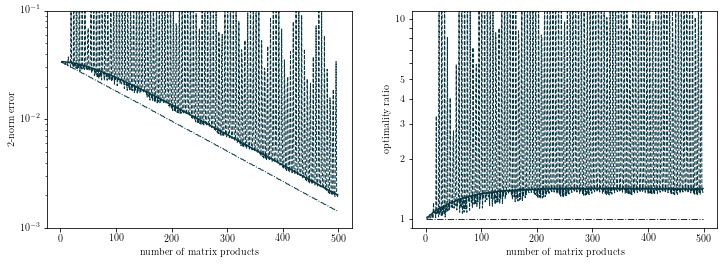

In [7]:
fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=False)
fig.subplots_adjust(wspace=.2,hspace=.05)


axs[0].plot(np.arange(K),error_FA/np.linalg.norm(b_vec),linestyle='--',lw=1,color='#073642',label='lanczos-FA')
axs[0].plot(np.arange(K),error_OR/np.linalg.norm(b_vec),linestyle='-',color='#073642',label='lanczos-OR')
axs[0].plot(np.arange(K),error_opt/np.linalg.norm(b_vec),linestyle='-.',lw=1,color='#073642',label='msCG')
axs[0].set_yscale('log')

axs[1].plot(np.arange(K),error_FA/error_opt,linestyle='--',lw=1,color='#073642',label='lanczos-FA')
axs[1].plot(np.arange(K),error_OR/error_opt,linestyle='-',color='#073642',label='lanczos-OR')
axs[1].plot(np.arange(K),error_opt/error_opt,linestyle='-.',lw=1,color='#073642',label='msCG')

axs[0].set_ylim(1e-3,1e-1)

axs[1].set_ylim(.9,11)
axs[1].set_yscale('log')
axs[1].set_yticks(np.arange(1,11))
axs[1].set_yticklabels([1,2,3,4,5,'','','','',10])

axs[0].set_xlabel('number of matrix products')
axs[1].set_xlabel('number of matrix products')

axs[0].set_ylabel('2-norm error')
axs[1].set_ylabel('optimality ratio')

plt.savefig('imgs/2norm_opt.pdf',bbox_inches='tight')